In [10]:
import psutil
print('-1:', psutil.virtual_memory()[3] / 1000000000)

from typing import Callable, Optional, Tuple
from fractions import Fraction

import functools
import torch
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
import pyro.contrib.gp as gp

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.robust.internals.utils import ParamDict
from chirho.robust.handlers.estimators import one_step_corrected_estimator 
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.predictive import PredictiveModel, PredictiveFunctional
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator
import psutil

# import profiling tools
from torch.profiler import profile, ProfilerActivity, record_function

pyro.settings.set(module_local_params=True)

sns.set_style("white")

pyro.set_rng_seed(32891) # for reproducibility

-1: 6.561726464


In [11]:
class CausalGLM(pyro.nn.PyroModule):
    def __init__(
        self,
        p: int,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: Optional[float] = None,
    ):
        super().__init__()
        self.p = p
        self.link_fn = link_fn
        if prior_scale is None:
            self.prior_scale = 1 / math.sqrt(self.p)
        else:
            self.prior_scale = prior_scale

    def sample_outcome_weights(self):
        return pyro.sample(
            "outcome_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_intercept(self):
        return pyro.sample("intercept", dist.Normal(0.0, 1.0))

    def sample_propensity_weights(self):
        return pyro.sample(
            "propensity_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_treatment_weight(self):
        return pyro.sample("treatment_weight", dist.Normal(0.0, 1.0))

    def sample_covariate_loc_scale(self):
        return torch.zeros(self.p), torch.ones(self.p)

    def forward(self):
        with record_function("causal_glm_forward"):
            intercept = self.sample_intercept()
            outcome_weights = self.sample_outcome_weights()
            propensity_weights = self.sample_propensity_weights()
            tau = self.sample_treatment_weight()
            x_loc, x_scale = self.sample_covariate_loc_scale()
            X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1))
            A = pyro.sample(
                "A",
                dist.Bernoulli(
                    logits=torch.einsum("...i,...i->...", X, propensity_weights)
                ),
            )
    
            return pyro.sample(
                "Y",
                self.link_fn(
                    torch.einsum("...i,...i->...", X, outcome_weights) + A * tau + intercept
                ),
            )

In [12]:
class ConditionedCausalGLM(CausalGLM):
    def __init__(
        self,
        X: torch.Tensor,
        A: torch.Tensor,
        Y: torch.Tensor,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: Optional[float] = None,
    ):
        p = X.shape[1]
        super().__init__(p, link_fn, prior_scale)
        self.X = X
        self.A = A
        self.Y = Y

    def forward(self):
        with record_function("conditioned_causal_glm_forward"):
            intercept = self.sample_intercept()
            outcome_weights = self.sample_outcome_weights()
            propensity_weights = self.sample_propensity_weights()
            tau = self.sample_treatment_weight()
            x_loc, x_scale = self.sample_covariate_loc_scale()
            with pyro.plate("__train__", size=self.X.shape[0], dim=-1):
                X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1), obs=self.X)
                A = pyro.sample(
                    "A",
                    dist.Bernoulli(
                        logits=torch.einsum("ni,i->n", self.X, propensity_weights)
                    ),
                    obs=self.A,
                )
                pyro.sample(
                    "Y",
                    self.link_fn(
                        torch.einsum("ni,i->n", X, outcome_weights)
                        + A * tau
                        + intercept
                    ),
                    obs=self.Y,
                )

In [13]:
class GroundTruthModel(CausalGLM):
    def __init__(
        self,
        p: int,
        alpha: int,
        beta: int,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        treatment_weight: float = 0.0,
    ):
        super().__init__(p, link_fn)
        self.alpha = alpha  # sparsity of propensity weights
        self.beta = beta  # sparsity of outcome weights
        self.treatment_weight = treatment_weight

    def sample_outcome_weights(self):
        outcome_weights = 1 / math.sqrt(self.beta) * torch.ones(self.p)
        outcome_weights[self.beta :] = 0.0
        return outcome_weights

    def sample_propensity_weights(self):
        propensity_weights = 1 / math.sqrt(self.alpha) * torch.ones(self.p)
        propensity_weights[self.alpha :] = 0.0
        return propensity_weights

    def sample_treatment_weight(self):
        return torch.tensor(self.treatment_weight)

    def sample_intercept(self):
        return torch.tensor(0.0)

In [14]:
def generate_data(p_dim, alpha, beta, N_train, N_test):
    true_model = GroundTruthModel(p_dim, alpha, beta)

    # Generate data
    D_train = Predictive(
        true_model, num_samples=N_train, return_sites=["X", "A", "Y"]
    )()
    D_test = Predictive(
        true_model, num_samples=N_test, return_sites=["X", "A", "Y"]
    )()
    return D_train, D_test

# N_datasets = len(simulated_datasets)

In [15]:
def fit_params(D_train, p_dim, alpha, beta):
    with record_function("fit_params"):
        # Fit the model
        start = time.time()
        conditioned_model = ConditionedCausalGLM(
                X=D_train["X"], A=D_train["A"], Y=D_train["Y"]
            )
        guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
        elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)
    
        # initialize parameters
        elbo()
        adam = torch.optim.Adam(elbo.parameters(), lr=0.03)
    
        # Do gradient steps
        for _ in range(2000):
            adam.zero_grad()
            loss = elbo()
            loss.backward()
            adam.step()
    
        model_fitting_time = time.time() - start
    
        theta_hat = {
            k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()
        }
    
        return theta_hat, model_fitting_time

In [16]:
# fitted_params = []
# model_fitting_time = []
# N_trials = 10
# for i in range(N_trials):
#     for p_dim in p_grid:
#         # Generate data
#         D_train, D_test = generate_data

#         start = time.time()
#         # Fit model using maximum likelihood
#         conditioned_model = ConditionedCausalGLM(
#             X=D_train["X"], A=D_train["A"], Y=D_train["Y"]
#         )
        
#         guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
#         elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

#         # initialize parameters
#         elbo()
#         adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

#         # Do gradient steps
#         for _ in range(2000):
#             adam.zero_grad()
#             loss = elbo()
#             loss.backward()
#             adam.step()

#         model_fitting_time.append(time.time() - start)

#         theta_hat = {
#             k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()
#         }
#         fitted_params.append(theta_hat)

In [17]:
class ATEFunctional(torch.nn.Module):
    def __init__(self, model: Callable, *, num_monte_carlo: int = 100):
        super().__init__()
        self.model = model
        self.num_monte_carlo = num_monte_carlo
    
    def forward(self, *args, **kwargs):
        with record_function("ate_functional"):
            with MultiWorldCounterfactual():
                with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                    with do(actions=dict(A=(torch.tensor(0.0), torch.tensor(1.0)))):
                        Ys = self.model(*args, **kwargs)
                    Y0 = gather(Ys, IndexSet(A={1}), event_dim=0)
                    Y1 = gather(Ys, IndexSet(A={2}), event_dim=0)
            ate = (Y1 - Y0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
            return pyro.deterministic("ATE", ate)
    
# Closed form expression
def closed_form_doubly_robust_ate_correction(X_test, theta) -> Tuple[torch.Tensor, torch.Tensor]:
    X = X_test["X"]
    A = X_test["A"]
    Y = X_test["Y"]
    pi_X = torch.sigmoid(X.mv(theta["propensity_weights"]))
    mu_X = (
        X.mv(theta["outcome_weights"])
        + A * theta["treatment_weight"]
        + theta["intercept"]
    )
    analytic_eif_at_test_pts = (A / pi_X - (1 - A) / (1 - pi_X)) * (Y - mu_X)
    analytic_correction = analytic_eif_at_test_pts.mean()
    return analytic_correction, analytic_eif_at_test_pts

# Helper class to create a trivial guide that returns the maximum likelihood estimate
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        with record_function("mle_guide"):
            for name in self.names:
                value = getattr(self, name + "_param")
                pyro.sample(
                    name, pyro.distributions.Delta(value, event_dim=len(value.shape))
                )


In [18]:
p=50  # memory scales with this because jvp is bad
alpha=50
beta=50
N_train=5000
N_test=500  # memory scales with this because the vmap operates over this dimension, with one jvp call each.

print('0:', psutil.virtual_memory()[3] / 1000000000)

D_train, D_test = generate_data(p, alpha, beta, N_train, N_test)
theta_hat, model_fitting_time = fit_params(D_train, p, alpha, beta)
# model_fitting_times[p].append(model_fitting_time)

mle_guide = MLEGuide(theta_hat)
functional = functools.partial(ATEFunctional, num_monte_carlo=10000)
ate_plug_in = functional(
    PredictiveModel(CausalGLM(p), mle_guide)
)()
analytic_correction, analytic_eif_at_test_pts = closed_form_doubly_robust_ate_correction(D_test, theta_hat)

# start = time.time()
monte_eif = influence_fn(functional, D_test)

print('A:', psutil.virtual_memory()[3] / 1000000000)

with MonteCarloInfluenceEstimator(
    num_samples_outer=1000,
    num_samples_inner=1,
    cg_iters=1
):
    with torch.no_grad():
        # with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True, with_stack=True) as prof:
        #     with record_function("monte_eif"):
        monte_eif_at_test_pts = monte_eif(PredictiveModel(CausalGLM(p), mle_guide))()
# end = time.time()
# automated_monte_carlo_times[p].append(end - start)
# automated_monte_carlo_at_test[p].append(monte_eif_at_test_pts)
# analytic_at_test[p].append(analytic_eif_at_test_pts)

# plug_in_ates[p].append(ate_plug_in.detach().item())
# analytic_corrections[p].append(ate_plug_in.detach().item() + analytic_correction.detach().item())

0: 6.577504256
A: 6.537003008


<Axes: ylabel='Count'>

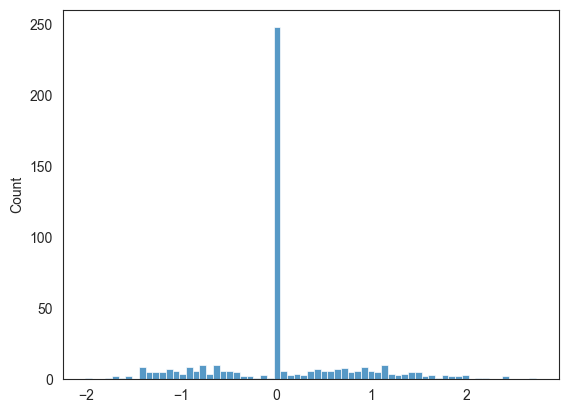

In [19]:
sns.histplot(monte_eif_at_test_pts.detach())

In [ ]:
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

In [ ]:
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

In [ ]:
prof.export_memory_timeline("/Users/azane/Desktop/mceif_prof.html")

In [ ]:
prof.export_chrome_trace("/Users/azane/Desktop/trace.json")

In [ ]:
# Memory profile the forward op of the glm.
with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True, with_stack=True) as glm_prof:
    with record_function("glm_forward"):
        # for pd in range(1, 1000):
        CausalGLM(p=1000)()

In [ ]:
print(glm_prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

In [ ]:
# Memory timeline.
glm_prof.export_memory_timeline("/Users/azane/Desktop/glm_prof.html")

In [ ]:
##################################################
# below not currently relevant to memory profile #
##################################################

In [ ]:
# Data configuration
alpha = 50
beta = 50
N_train = 500
N_test = 50
p_grid = [1, 10, 25, 50, 100, 150, 200, 250, 300, 500]


# Compute doubly robust ATE estimates using both the automated and closed form expressions
N_trials = 25

import pickle
import os

RESULTS_PATH = 'results/error_vs_dimension.pkl'

if os.path.exists(RESULTS_PATH):
    with open(RESULTS_PATH, 'rb') as f:
        results = pickle.load(f)
        plug_in_ates = results['plug_in_ates']
        model_fitting_times = results['model_fitting_times']
        analytic_corrections = results['analytic_corrections']
        automated_monte_carlo_corrections = results['automated_monte_carlo_corrections']
        automated_monte_carlo_at_test = results['automated_monte_carlo_at_test']
        automated_monte_carlo_times = results['automated_monte_carlo_times']
        analytic_at_test = results['analytic_at_test']
    i_start = len(plug_in_ates[p_grid[0]])
else:
    plug_in_ates = {p:[] for p in p_grid}
    model_fitting_times = {p:[] for p in p_grid}
    analytic_corrections = {p:[] for p in p_grid}
    automated_monte_carlo_corrections = {p:[] for p in p_grid}
    automated_monte_carlo_at_test = {p:[] for p in p_grid}
    automated_monte_carlo_times = {p:[] for p in p_grid}
    analytic_at_test = {p:[] for p in p_grid}
    i_start = 0

for i in range(i_start, N_trials):
    for p in p_grid:
        print(i, p)
        D_train, D_test = generate_data(p, alpha, beta, N_train, N_test)
        theta_hat, model_fitting_time = fit_params(D_train, p, alpha, beta)
        model_fitting_times[p].append(model_fitting_time)

        mle_guide = MLEGuide(theta_hat)
        functional = functools.partial(ATEFunctional, num_monte_carlo=10000)
        ate_plug_in = functional(
            PredictiveModel(CausalGLM(p), mle_guide)
        )()
        analytic_correction, analytic_eif_at_test_pts = closed_form_doubly_robust_ate_correction(D_test, theta_hat)

        start = time.time()
        monte_eif = influence_fn(functional, D_test, num_samples_outer=10000, num_samples_inner=1)
        monte_eif_at_test_pts = monte_eif(PredictiveModel(CausalGLM(p), mle_guide))()
        end = time.time()
        automated_monte_carlo_times[p].append(end - start)
        automated_monte_carlo_at_test[p].append(monte_eif_at_test_pts)
        analytic_at_test[p].append(analytic_eif_at_test_pts)

        plug_in_ates[p].append(ate_plug_in.detach().item())
        analytic_corrections[p].append(ate_plug_in.detach().item() + analytic_correction.detach().item())
        # automated_monte_carlo_corrections[p].append(ate_plug_in.detach().item() + monte_eif_at_test_pts.mean().detach().item())

    with open(RESULTS_PATH, 'wb') as f:
        results = {
            'plug_in_ates': plug_in_ates,
            'model_fitting_times': model_fitting_times,
            'analytic_corrections': analytic_corrections,
            'automated_monte_carlo_corrections': automated_monte_carlo_corrections,
            'automated_monte_carlo_at_test': automated_monte_carlo_at_test,
            'automated_monte_carlo_times': automated_monte_carlo_times,
            'analytic_at_test': analytic_at_test
        }
        pickle.dump(results, f)


In [ ]:
def median_rel_error(x, y):
    x = torch.tensor(x)
    y = torch.tensor(y)
    return torch.median(torch.abs(x - y) / torch.abs(y))

In [ ]:
monte_eif_errors = {p: torch.tensor([median_rel_error(x, y) for x, y in zip(automated_monte_carlo_at_test[p], analytic_at_test[p])]) for p in p_grid}
monte_eif_error_means = {p: monte_eif_errors[p].mean() for p in p_grid}
monte_eif_error_stderrs = {p: monte_eif_errors[p].std() / math.sqrt(N_trials) for p in p_grid}

In [ ]:
model_dimension_grid = [2 * p + 2 for p in p_grid]
unpacked_model_dimension_grid = [2 * p + 2 for p in p_grid for _ in monte_eif_errors[p]]
unpacked_monte_eif_errors = [e.item() for p in p_grid for e in monte_eif_errors[p]]

In [ ]:
obs_rate_num

In [ ]:
obs_rate_denom

In [ ]:
plt.figure(figsize=(6, 4))

plt.rcParams['text.usetex'] = True

obs_slope, obs_intercept = np.polyfit(
    np.log10(unpacked_model_dimension_grid), 
    np.log10(unpacked_monte_eif_errors), 1)

theory_slope = 1/2
theory_intercept = (np.log10(unpacked_monte_eif_errors) - theory_slope * np.log10(unpacked_model_dimension_grid)).mean()

# Plot results
plt.errorbar(model_dimension_grid, 
             list(monte_eif_error_means.values()), 
             yerr=list(monte_eif_error_stderrs.values()), 
             fmt='.-',
             label='MC-EIF (10k Monte Carlo samples)',
             color='#154c79',
             marker='o')
obs_rate_num = Fraction(int(round(8*obs_slope)),8).numerator
obs_rate_denom = Fraction(int(round(8*obs_slope)),8).denominator
plt.plot(model_dimension_grid, 
    10**obs_intercept * np.power(model_dimension_grid, obs_slope), 
    label='Estimated Error Rate: O($p^{7/16}$)',
    color='red',
    linestyle='--'
)
plt.plot(model_dimension_grid, 
    10**theory_intercept * np.power(model_dimension_grid, theory_slope), 
    label='Our Theory: O($p^{1/2}$)',
    color='green',
    linestyle='--'
)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Median Relative Error', fontsize=24)
plt.xlabel('Model Dimension (p)', fontsize=24)
sns.despine()
plt.legend(fontsize=13)

plt.yticks([0.01, 0.1, 0.5], fontsize=20)
plt.xticks([10, 100, 1000], fontsize=20)
plt.tight_layout()
plt.savefig('./figures/error_rate_causal_glm_vs_dim.png')

In [ ]:
model_fitting_times

In [ ]:
automated_monte_carlo_time_means = {p: np.mean(automated_monte_carlo_times[p]) for p in p_grid}
automated_monte_carlo_time_stderrs = {p: np.std(automated_monte_carlo_times[p]) / math.sqrt(N_trials) for p in p_grid}

model_fitting_time_means = {p: np.mean(model_fitting_times[p]) for p in p_grid}
model_fitting_time_stderrs = {p: np.std(model_fitting_times[p]) / math.sqrt(N_trials) for p in p_grid}

In [ ]:
# Plot results

plt.errorbar(model_dimension_grid, 
             list(automated_monte_carlo_time_means.values()), 
             yerr=list(automated_monte_carlo_time_stderrs.values()), 
             fmt='.-',
             label='MC-EIF (10k Monte Carlo samples)',
             color='#154c79',
             marker='o')

plt.errorbar(model_dimension_grid,
                list(model_fitting_time_means.values()),
                yerr=list(model_fitting_time_stderrs.values()),
                fmt='.-',
                label='Model Fitting Time',
                color='#f95d6a',
                marker='o'
    )

# plt.plot(
#     model_dimension_grid, 
#     model_fitting_time, 
#     label='Model Fitting Time', 
#     color='#f95d6a',
#     marker='o'

# )
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Runtime (s)', fontsize=24)
plt.xlabel('Model Dimension (p)', fontsize=24)
sns.despine()
plt.legend(fontsize=13)
plt.tight_layout()
# plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5], fontsize=20)
# plt.xticks([10, 100, 1000], fontsize=20)
plt.savefig('./figures/runtime_causal_glm_vs_dim.png')